# Lab 11, Aleksandr Berezutskii, group 4, Skoltech 2018

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The objective of this laboratory work is to develop a navigation filter by assimilating data coming from different sources. Important outcome of this exercise is getting skill to incorporate all available measurement information into assimilation algorithm and develop a tracking filter for nonlinear models.

Let's first generate a true trajectory $X_i$ of an object motion disturbed by normally distributed random acceleration

$$
x_i = x_{i-1} + v_{i-1}^x T + \frac{a_{i-1}^x T^2}{2}
$$

$$
v_{i}^x = v_{i-1}^x + a_{i-1}^x T
$$

$$
y_i = y_{i-1} + v_{i-1}^y T + \frac{a_{i-1}^y T^2}{2}
$$

$$
v_{i}^y = v_{i-1}^y + a_{i-1}^y T
$$

Initial conditions to generate trajectory:

1. Size is $N=500$ points
2. Interval between measurements $T=2$
3. Initial coordinates: $x_0 = 1000$ and $y_0 = 1000$
4. Initial components of velocity $\vec{v}$: $v_0^x = v_0^y = 100$
5. Variance of noise $a_i$ distribution $\sigma_a^2 = 0.3^2$ for both $x$ and $y$ components

In [2]:
#N is the size of trajectory
N = 500

#T is the interval between measurements
T = 2

#Noise of acceleration
sigma_a = 0.3
a_x = np.random.normal(loc=0.0, scale=sigma_a, size=N)
a_y = np.random.normal(loc=0.0, scale=sigma_a, size=N)

#Now let's create the trajectory
x = np.zeros(N)
x[0] = 1000

y = np.zeros(N)
y[0] = 1000

v_x = np.zeros(N)
v_x[0] = 100

v_y = np.zeros(N)
v_y[0] = 100

for i in range(1,N):
    x[i] = x[i-1] + v_x[i-1]*T + a_x[i-1]*(T**2)/2
    v_x[i] = v_x[i-1] + a_x[i-1]*T
    y[i] = y[i-1] + v_y[i-1]*T + a_y[i-1]*(T**2)/2
    v_y[i] = v_y[i-1] + a_y[i-1]*T

We will now also calculate true values of range $D$ and azimuth $\beta$:

$$
D_i = \sqrt{x_i^2 + y_i^2}
$$

$$
\beta_i = arctg \frac{x_i}{y_i}
$$

In [3]:
D = np.zeros(N)
B = np.zeros(N)

for i in range(N):
    D[i] = np.sqrt(x[i]**2 + y[i]**2)
    B[i] = np.arctan(x[i] / y[i])

Now we will generate measurements $D^m$ and $\beta^m$ of range $D$ and azimuth $\beta$ provided by the first observer that arrive on odd time steps:

$$
D_i^m = D_i + \eta_i^D
$$

$$
\beta_i^m = \beta_i + \eta_i^\beta
$$


Where $i=1,3,5,...,N-1$ and $\eta$'s are random Gaussian noises with the following variances:

$$
\sigma_\eta^D = 50
$$

$$
\sigma_\eta^\beta = 0.004
$$

In [4]:
#noise of D
sigma_eta_D = 50
eta_D = np.random.normal(loc=0.0, scale=sigma_eta_D, size=N)

#noise of beta
sigma_eta_B = 0.004
eta_B = np.random.normal(loc=0.0, scale=sigma_eta_B, size=N)

#Now let's generate measurements, nans will be useful later
D_m = np.zeros(N)
D_m[:] = np.nan
B_m = np.zeros(N)
B_m[:] = np.nan

for i in range(0, N-1, 2):
    D_m[i] = D[i] + eta_D[i]
    B_m[i] = B[i] + eta_B[i]

Now we will generate more accurate measurements $\beta^{m, add}$ of azimuth $\beta$ provided by the second observer that arrive on even steps:

$$
\beta_i^{m, add} = \beta_i + \eta_i^{\beta, add}
$$


Where $i=4, 6, 8, ...,N-2$ and $\eta$'s are random Gaussian noises with the following variance:

$$
\sigma_\eta^{\beta, add} = 0.001
$$

In [5]:
#noise of beta_add
sigma_eta_B_add = 0.001
eta_B_add = np.random.normal(loc=0.0, scale=sigma_eta_B_add, size=N)

#Now let's generate measurements
B_m_add = np.zeros(N)
B_m_add[:] = np.nan

for i in range(3, N, 2):
    B_m_add[i] = B[i] + eta_B_add[i]

In [6]:
#B_m's and D_m's go 0, 2, 4, ...
#B_m_add's go 3, 5, 7, ...

#Making measurement vector z
z1 = np.zeros((N, 2, 1))
z2 = np.zeros((N, 1, 1))
for i in range(N):
    z1[i] = np.matrix([[D_m[i]], 
                      [B_m[i]]])
    z2[i] = np.matrix([[B_m_add[i]]])
    
h1 = np.zeros((N, 2, 1))
h2 = np.zeros((N))

In [7]:
#Let's do everything simultaniposly for both observers
#Making state vector
X = np.zeros((N, 4, 1))
for i in range(N):
    X[i] = np.matrix([[x[i]], 
                      [v_x[i]], 
                      [y[i]], 
                      [v_y[i]]])
#Initial state vector
X[4] = np.matrix([[D_m[4] * np.sin(B_m[4])],
                  [(D_m[4] * np.sin(B_m[4]) - D_m[2] * np.sin(B_m[4]))/(2*T)],
                  [D_m[4] * np.cos(B_m[4])],
                  [(D_m[4] * np.cos(B_m[4]) - D_m[2] * np.cos(B_m[4]))/2*T]])
 
#Making filtration error covariance matrix P
P = np.zeros((N, 4, 4))
for i in range(N):
    P[i] = np.matrix([[0, 0, 0, 0],
                      [0, 0, 0, 0],
                      [0, 0, 0, 0],
                      [0, 0, 0, 0]])

#Initial filtration error covariance matrix
P[0] = np.identity(4) * 10**4

#Making a transition matrix
PHI = np.matrix([[1, T, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 1, T],
                 [0, 0, 0, 1]])

#Making an input matrix
G = np.matrix([[(T**2)/2, T, 0, 0],
               [0, 0, (T**2)/2, T]]).T

#Calculating state noise covariance matrix Q
Q = sigma_a**2 * G @ G.T

#Making measurement error covariance matrices
R1 = np.matrix([[sigma_eta_D**2, 0],
               [0, sigma_eta_B**2]])

R2 = sigma_eta_B_add**2

In [8]:
# Let's start Kalman filter algorithm
D_Kalman_Predict = np.zeros(N)
D_Kalman_Predict[:] = np.nan
B_Kalman_Predict = np.zeros(N)
B_Kalman_Predict[:] = np.nan
D_Kalman_Filter = np.zeros(N)
D_Kalman_Filter[:] = np.nan
B_Kalman_Filter = np.zeros(N)
B_Kalman_Filter[:] = np.nan
dhdx1 = np.zeros((N, 2, 4))
dhdx2 = np.zeros((N, 1, 4))

K1 = np.zeros((N, 4, 2))
K2 = np.zeros((N, 4, 1))

#B_m's and D_m's go 0, 2, 4, ...
#B_m_add's go 3, 5, 7, ...
for i in range(4, N-1):
    if i % 2 == 0 :
        #Second observer starts first
        #Prediction of the state vector
        X[i+1] = PHI @ X[i]
        D_Kalman_Predict[i+1] = (X[i+1,0]**2 + X[i+1,2]**2) ** 0.5
        B_Kalman_Predict[i+1] = np.arctan(X[i+1,0]/X[i+1,2])
        dhdx2[i+1] = np.matrix([[np.cos(B_Kalman_Predict[i+1]) / D_Kalman_Predict[i+1], 0, - np.sin(B_Kalman_Predict[i+1]) / D_Kalman_Predict[i+1], 0]])
    
        #Prediction error covariance matrix
        P[i+1] = PHI @ P[i] @ PHI.T + Q
    
        #Filtration
        K2[i+1] = P[i+1] @ dhdx2[i+1].T * (dhdx2[i+1] @ P[i+1] @ dhdx2[i+1].T + R2)**(-1)
        h2[i+1] = np.array([B_Kalman_Predict[i+1]])
        X[i+1] = X[i+1] + K2[i+1] * (z2[i+1] - h2[i+1])
        D_Kalman_Filter[i+1] = (X[i+1,0]**2 + X[i+1,2]**2) ** 0.5
        B_Kalman_Filter[i+1] = np.arctan(X[i+1,0]/X[i+1,2])

        #Filtration error covariance matrix
        P[i+1] = (np.identity(np.shape(P[0])[0]) - K2[i+1] @ dhdx2[i+1]) @ P[i+1]
    else:
        #First observer starts second
        #Prediction of the state vector
        X[i+1] = PHI @ X[i]
        D_Kalman_Predict[i+1] = (X[i+1,0]**2 + X[i+1,2]**2) ** 0.5
        B_Kalman_Predict[i+1] = np.arctan(X[i+1,0]/X[i+1,2])
        dhdx1[i+1] = np.matrix([[np.sin(B_Kalman_Predict[i+1]), 0, np.cos(B_Kalman_Predict[i+1]), 0], 
                           [np.cos(B_Kalman_Predict[i+1]) / D_Kalman_Predict[i+1], 0, -np.sin(B_Kalman_Predict[i+1]) / D_Kalman_Predict[i+1], 0]])
    
        #Prediction error covariance matrix
        P[i+1] = PHI @ P[i] @ PHI.T + Q
    
        #Filtration
        K1[i+1] = P[i+1] @ dhdx1[i+1].T @ np.linalg.inv(dhdx1[i+1] @ P[i+1] @ dhdx1[i+1].T + R1)
        h1[i+1] = np.matrix([[D_Kalman_Predict[i+1]], 
                          [B_Kalman_Predict[i+1]]])
        X[i+1] = X[i+1] + K1[i+1] @ (z1[i+1] - h1[i+1])

        D_Kalman_Filter[i+1] = (X[i+1,0]**2 + X[i+1,2]**2) ** 0.5
        B_Kalman_Filter[i+1] = np.arctan(X[i+1,0]/X[i+1,2])

        #Filtration error covariance matrix
        P[i+1] = (np.identity(np.shape(P[0])[0]) - K1[i+1] @ dhdx1[i+1]) @ P[i+1]

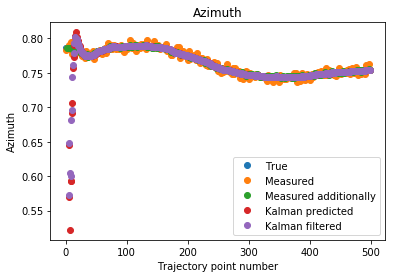

In [9]:
plt.plot(B, 'o')
plt.plot(B_m, 'o')
plt.plot(B_m_add, 'o')
plt.plot(B_Kalman_Predict, 'o')
plt.plot(B_Kalman_Filter, 'o')
plt.xlabel('Trajectory point number')
plt.ylabel('Azimuth')
plt.title('Azimuth')
plt.legend(['True', 'Measured', 'Measured additionally', 'Kalman predicted', 'Kalman filtered'], loc = 'best')
plt.show()

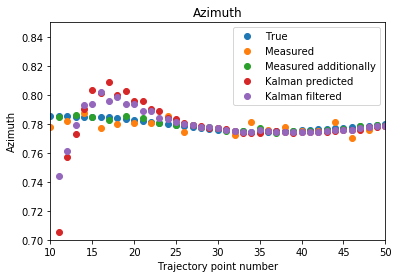

In [10]:
plt.plot(B, 'o')
plt.plot(B_m, 'o')
plt.plot(B_m_add, 'o')
plt.plot(B_Kalman_Predict, 'o')
plt.plot(B_Kalman_Filter, 'o')
plt.xlim((10,50))
plt.ylim((0.7, 0.85))
plt.xlabel('Trajectory point number')
plt.ylabel('Azimuth')
plt.title('Azimuth')
plt.legend(['True', 'Measured', 'Measured additionally', 'Kalman predicted', 'Kalman filtered'], loc = 'best')
plt.show()

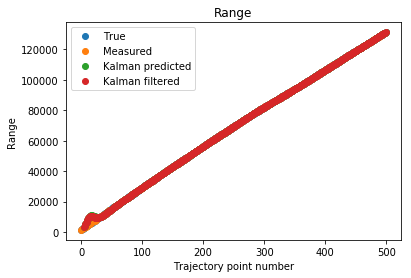

In [11]:
plt.plot(D, 'o')
plt.plot(D_m, 'o')
plt.plot(D_Kalman_Predict, 'o')
plt.plot(D_Kalman_Filter, 'o')
plt.xlabel('Trajectory point number')
plt.ylabel('Range')
plt.title('Range')
plt.legend(['True', 'Measured', 'Kalman predicted', 'Kalman filtered'], loc = 'best')
plt.show()

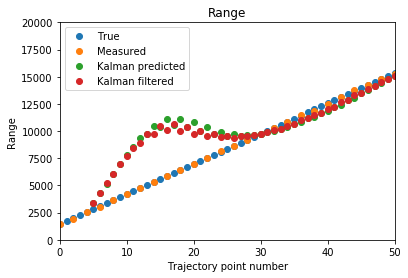

In [12]:
plt.plot(D, 'o')
plt.plot(D_m, 'o')
plt.plot(D_Kalman_Predict, 'o')
plt.plot(D_Kalman_Filter, 'o')
plt.xlabel('Trajectory point number')
plt.ylabel('Range')
plt.title('Range')
plt.xlim((0,50))
plt.ylim((0,20000))
plt.legend(['True', 'Measured', 'Kalman predicted', 'Kalman filtered'], loc = 'best')
plt.show()

Let's run the filter 500 times to analyze errors

In [18]:
# M is the total number of runs
M=500
Errors_prediction_squared_D = np.zeros((M, N))
Errors_prediction_squared_D[:] = np.nan
Errors_filtration_squared_D = np.zeros((M, N))
Errors_filtration_squared_D[:] = np.nan
Errors_prediction_squared_B = np.zeros((M, N))
Errors_prediction_squared_B[:] = np.nan
Errors_filtration_squared_B = np.zeros((M, N))
Errors_filtration_squared_B[:] = np.nan

for j in range(M):

   #N is the size of trajectory
    N = 500

    #T is the interval between measurements
    T = 2

    #Noise of acceleration
    sigma_a = 0.3
    a_x = np.random.normal(loc=0.0, scale=sigma_a, size=N)
    a_y = np.random.normal(loc=0.0, scale=sigma_a, size=N)

    #Now let's create the trajectory
    x = np.zeros(N)
    x[0] = 1000

    y = np.zeros(N)
    y[0] = 1000

    v_x = np.zeros(N)
    v_x[0] = 100

    v_y = np.zeros(N)
    v_y[0] = 100

    for i in range(1,N):
        x[i] = x[i-1] + v_x[i-1]*T + a_x[i-1]*(T**2)/2
        v_x[i] = v_x[i-1] + a_x[i-1]*T
        y[i] = y[i-1] + v_y[i-1]*T + a_y[i-1]*(T**2)/2
        v_y[i] = v_y[i-1] + a_y[i-1]*T
        

    D = np.zeros(N)
    B = np.zeros(N)

    for i in range(N):
        D[i] = np.sqrt(x[i]**2 + y[i]**2)
        B[i] = np.arctan(x[i] / y[i])

    #noise of D
    sigma_eta_D = 50
    eta_D = np.random.normal(loc=0.0, scale=sigma_eta_D, size=N)

    #noise of beta
    sigma_eta_B = 0.004
    eta_B = np.random.normal(loc=0.0, scale=sigma_eta_B, size=N)

    #Now let's generate measurements, nans will be useful later
    D_m = np.zeros(N)
    D_m[:] = np.nan
    B_m = np.zeros(N)
    B_m[:] = np.nan

    for i in range(0, N-1, 2):
        D_m[i] = D[i] + eta_D[i]
        B_m[i] = B[i] + eta_B[i]

    
    #noise of beta_add
    sigma_eta_B_add = 0.001
    eta_B_add = np.random.normal(loc=0.0, scale=sigma_eta_B_add, size=N)

    #Now let's generate measurements
    B_m_add = np.zeros(N)
    B_m_add[:] = np.nan

    for i in range(3, N, 2):
        B_m_add[i] = B[i] + eta_B_add[i]
    
    
    #Making measurement vector z
    z1 = np.zeros((N, 2, 1))
    z2 = np.zeros((N, 1, 1))
    for i in range(N):
        z1[i] = np.matrix([[D_m[i]], 
                          [B_m[i]]])
        z2[i] = np.matrix([[B_m_add[i]]])

    h1 = np.zeros((N, 2, 1))
    h2 = np.zeros((N))
    
    
    #Let's do everything simultaniposly for both observers
    #Making state vector
    X = np.zeros((N, 4, 1))
    for i in range(N):
        X[i] = np.matrix([[x[i]], 
                          [v_x[i]], 
                          [y[i]], 
                          [v_y[i]]])
    #Initial state vector
    X[4] = np.matrix([[D_m[4] * np.sin(B_m[4])],
                      [(D_m[4] * np.sin(B_m[4]) - D_m[2] * np.sin(B_m[4]))/(2*T)],
                      [D_m[4] * np.cos(B_m[4])],
                      [(D_m[4] * np.cos(B_m[4]) - D_m[2] * np.cos(B_m[4]))/2*T]])

    #Making filtration error covariance matrix P
    P = np.zeros((N, 4, 4))
    for i in range(N):
        P[i] = np.matrix([[0, 0, 0, 0],
                          [0, 0, 0, 0],
                          [0, 0, 0, 0],
                          [0, 0, 0, 0]])

    #Initial filtration error covariance matrix
    P[0] = np.identity(4) * 10**4

    #Making a transition matrix
    PHI = np.matrix([[1, T, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, T],
                     [0, 0, 0, 1]])

    #Making an input matrix
    G = np.matrix([[(T**2)/2, T, 0, 0],
                   [0, 0, (T**2)/2, T]]).T

    #Calculating state noise covariance matrix Q
    Q = sigma_a**2 * G @ G.T

    #Making measurement error covariance matrices
    R1 = np.matrix([[sigma_eta_D**2, 0],
                   [0, sigma_eta_B**2]])

    R2 = sigma_eta_B_add**2
    
    # Let's start Kalman filter algorithm
    D_Kalman_Predict = np.zeros(N)
    D_Kalman_Predict[:] = np.nan
    B_Kalman_Predict = np.zeros(N)
    B_Kalman_Predict[:] = np.nan
    D_Kalman_Filter = np.zeros(N)
    D_Kalman_Filter[:] = np.nan
    B_Kalman_Filter = np.zeros(N)
    B_Kalman_Filter[:] = np.nan
    dhdx1 = np.zeros((N, 2, 4))
    dhdx2 = np.zeros((N, 1, 4))

    K1 = np.zeros((N, 4, 2))
    K2 = np.zeros((N, 4, 1))

    #B_m's and D_m's go 0, 2, 4, ...
    #B_m_add's go 3, 5, 7, ...
    for i in range(4, N-1):
        if i % 2 == 0 :
            #Second observer starts first
            #Prediction of the state vector
            X[i+1] = PHI @ X[i]
            D_Kalman_Predict[i+1] = (X[i+1,0]**2 + X[i+1,2]**2) ** 0.5
            B_Kalman_Predict[i+1] = np.arctan(X[i+1,0]/X[i+1,2])
            dhdx2[i+1] = np.matrix([[np.cos(B_Kalman_Predict[i+1]) / D_Kalman_Predict[i+1], 0, - np.sin(B_Kalman_Predict[i+1]) / D_Kalman_Predict[i+1], 0]])

            #Errors
            Errors_prediction_squared_B[j, i] = (B_Kalman_Predict[i] - B_m[i])**2
            Errors_prediction_squared_D[j, i] = (D_Kalman_Predict[i] - D_m[i])**2
            
            #Prediction error covariance matrix
            P[i+1] = PHI @ P[i] @ PHI.T + Q

            #Filtration
            K2[i+1] = P[i+1] @ dhdx2[i+1].T * (dhdx2[i+1] @ P[i+1] @ dhdx2[i+1].T + R2)**(-1)
            h2[i+1] = np.array([B_Kalman_Predict[i+1]])
            X[i+1] = X[i+1] + K2[i+1] * (z2[i+1] - h2[i+1])
            D_Kalman_Filter[i+1] = (X[i+1,0]**2 + X[i+1,2]**2) ** 0.5
            B_Kalman_Filter[i+1] = np.arctan(X[i+1,0]/X[i+1,2])
            a[i+1] = D_Kalman_Filter[i+1]

            #Filtration error covariance matrix
            P[i+1] = (np.identity(np.shape(P[0])[0]) - K2[i+1] @ dhdx2[i+1]) @ P[i+1]
            
            #Errors
            Errors_filtration_squared_D[j, i] = (D_Kalman_Filter[i] - D_m[i])**2
            Errors_filtration_squared_B[j, i] = (B_Kalman_Filter[i] - B_m[i])**2
            
        else:
            #First observer starts second
            #Prediction of the state vector
            X[i+1] = PHI @ X[i]
            D_Kalman_Predict[i+1] = (X[i+1,0]**2 + X[i+1,2]**2) ** 0.5
            B_Kalman_Predict[i+1] = np.arctan(X[i+1,0]/X[i+1,2])
            dhdx1[i+1] = np.matrix([[np.sin(B_Kalman_Predict[i+1]), 0, np.cos(B_Kalman_Predict[i+1]), 0], 
                               [np.cos(B_Kalman_Predict[i+1]) / D_Kalman_Predict[i+1], 0, -np.sin(B_Kalman_Predict[i+1]) / D_Kalman_Predict[i+1], 0]])

            #Prediction error covariance matrix
            P[i+1] = PHI @ P[i] @ PHI.T + Q
            
            #Errors
            Errors_prediction_squared_B[j, i] = (B_Kalman_Predict[i] - B_m_add[i])**2

            #Filtration
            K1[i+1] = P[i+1] @ dhdx1[i+1].T @ np.linalg.inv(dhdx1[i+1] @ P[i+1] @ dhdx1[i+1].T + R1)
            h1[i+1] = np.matrix([[D_Kalman_Predict[i+1]], 
                              [B_Kalman_Predict[i+1]]])
            X[i+1] = X[i+1] + K1[i+1] @ (z1[i+1] - h1[i+1])

            D_Kalman_Filter[i+1] = (X[i+1,0]**2 + X[i+1,2]**2) ** 0.5
            B_Kalman_Filter[i+1] = np.arctan(X[i+1,0]/X[i+1,2])

            #Filtration error covariance matrix
            P[i+1] = (np.identity(np.shape(P[0])[0]) - K1[i+1] @ dhdx1[i+1]) @ P[i+1]
            
            #Errors
            Errors_filtration_squared_D[j, i] = (D_Kalman_Filter[i] - (D_m[i-1]+D_m[i+1])/2)**2
            Errors_filtration_squared_B[j, i] = (B_Kalman_Filter[i] - B_m_add[i])**2
            
Fin_Err_prediction_squared_D = np.zeros(N)
Fin_Err_filtration_squared_D = np.zeros(N)
Fin_Err_prediction_squared_B = np.zeros(N)
Fin_Err_filtration_squared_B = np.zeros(N)
for i in range(4, N-1):
    for j in range(M):
        Fin_Err_prediction_squared_D[i] += (1/(M-1))*Errors_prediction_squared_D[j, i]
        Fin_Err_filtration_squared_D[i] += (1/(M-1))*Errors_filtration_squared_D[j, i]
        Fin_Err_prediction_squared_B[i] += (1/(M-1))*Errors_prediction_squared_B[j, i]
        Fin_Err_filtration_squared_B[i] += (1/(M-1))*Errors_filtration_squared_B[j, i]

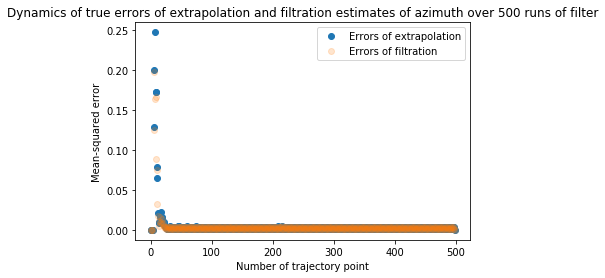

In [19]:
plt.plot(np.sqrt(Fin_Err_prediction_squared_B), 'o')
plt.plot(np.sqrt(Fin_Err_filtration_squared_B), 'o', alpha = 0.2)
plt.title('Dynamics of true errors of extrapolation and filtration estimates of azimuth over 500 runs of filter')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Errors of extrapolation', 'Errors of filtration'], loc = 'best')
plt.show()

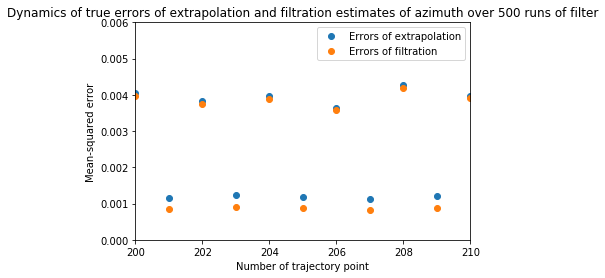

In [20]:
plt.plot(np.sqrt(Fin_Err_prediction_squared_B), 'o')
plt.plot(np.sqrt(Fin_Err_filtration_squared_B), 'o')
plt.title('Dynamics of true errors of extrapolation and filtration estimates of azimuth over 500 runs of filter')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Errors of extrapolation', 'Errors of filtration'], loc = 'best')
plt.xlim((200,210))
plt.ylim((0,0.006))
plt.show()

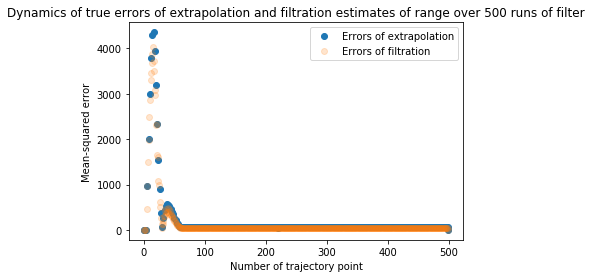

In [21]:
plt.plot(np.sqrt(Fin_Err_prediction_squared_D), 'o')
plt.plot(np.sqrt(Fin_Err_filtration_squared_D), 'o', alpha = 0.2)
plt.title('Dynamics of true errors of extrapolation and filtration estimates of range over 500 runs of filter')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Errors of extrapolation', 'Errors of filtration'], loc = 'best')
plt.show()

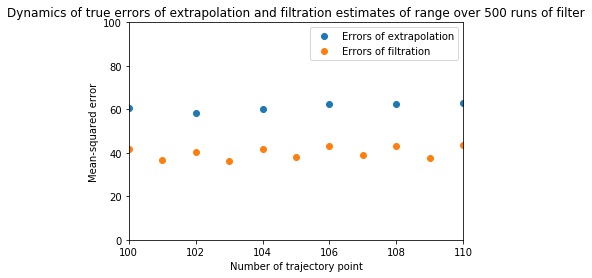

In [22]:
plt.plot(np.sqrt(Fin_Err_prediction_squared_D), 'o')
plt.plot(np.sqrt(Fin_Err_filtration_squared_D), 'o')
plt.title('Dynamics of true errors of extrapolation and filtration estimates of range over 500 runs of filter')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Errors of extrapolation', 'Errors of filtration'], loc = 'best')
plt.xlim((100,110))
plt.ylim((0,100))
plt.show()

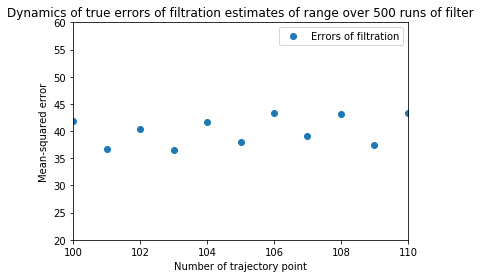

In [25]:
plt.plot(np.sqrt(Fin_Err_filtration_squared_D), 'o')
plt.title('Dynamics of true errors of filtration estimates of range over 500 runs of filter')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Errors of filtration'], loc = 'best')
plt.xlim((100,110))
plt.ylim((20,60))
plt.show()

Error of $D$ also depends on step number, but we only fixed $\beta$!

### Conclusion
Accuracy of estimation varies for odd and even time steps for $D$ also, because on an even step we use extra measurements to calculate another variable which helps us in the other branch of our Kalman filter loop